## Library imports

In [57]:
import os
import re
import json
import pickle
import contractions
import seaborn as sns
import numpy as np
import statistics
from collections import Counter
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D
from keras.initializers import Constant
from keras.optimizers import Adam
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

STOPWORDS = set(stopwords.words('english'))
directory = './data/'
mapping_file = './data/metadata/mapping_conv_topic.train.txt'
embedding_vectors_path = './embedding_data/glove.6B.200d.txt'
models_path = './models/'

## Necessary functions

In [3]:
def draw_distribution(data, title):
    '''
    Function to draw the distribution of classs.
    
    Args:
        data (dict) : dictionary with frequency of each key
        title (str) : title to be printed with the distribution plot
    '''
    ind = range(len(data))
    width = 0.9
    pt = plt.bar(ind, data.values(), width, color=plt.cm.Paired(np.arange(len(data))))

    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(ind, data.keys(), rotation=90)

    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()/2., 0.995*height, '%d' % int(height), ha='center', va='bottom')
    autolabel(pt)

    plt.show()

In [4]:
def fetch_clean_conversation(filepath):
    '''
    Function to read individual txt files, read line by line and clean the text for further processing.
    
    Args:
        filepath (path) : path to the individual training txt file
    Return:
        convo (str) : clean string of the individual training txt file
    '''
    # fetch the text words after the person name, start time and end time in each line
    convo = [' '.join(line.split()[3:]) for line in open(filepath, 'r').read().split('\n') if line]
    # removing unwanted brace words which are [silence], [noise], [vocalized-noice], [laughter], <b_aside> and <e_aside>
    convo = [re.sub('\[silence\]|\[noise\]|\[vocalized\-noise\]|\[laughter\]|_1|<b_aside>|<e_aside>', '', word) for line in convo for word in line.split()]
    # cleaning the brace words which has first words as laughter. Removing braces and laughter- to retain only the second word
    convo = [re.sub('laughter\-', '', word) if re.findall('\[laughter\-.*\]', word) else word for word in convo]
    # removing unwanted braces from remaining words
    convo = [re.sub('\[|\]', '', word) for word in convo]
    # replacing '-' with spaces and stitching the words
    convo = ' '.join(' '.join([contractions.fix(re.sub('\-', ' ', word)).lower() for word in convo]).split())
    # remoaving all the non alphabetic characters and stitching back all the remaining text
    convo = ''.join([char if char.isalpha() else ' ' for char in convo])
    
    return convo

In [5]:
def plot_results(y_test, y_pred, model_name):
    '''
    Function to plot results as confusion matrix.
    
    Args:
        y_test (list) : list of expected test_y values
        y_pred (list) : list of predicted values by model
        model_name (str) : name of the model trained
    '''
    cm = metrics.confusion_matrix(y_test, y_pred)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(model_name + ' - Confusion Matrix'); 
    ax.xaxis.set_ticklabels(list(label_dict.values()), rotation='90'); ax.yaxis.set_ticklabels(list(label_dict.values()), rotation='0');

    # Printing the precision and recall, among other metrics
    print(metrics.classification_report(y_test, y_pred))

In [6]:
def plot_history(history):
    '''
    Function to plot tthe graph of the training and validation accuracy and loss values for each epochs.
    
    Args:
        history (tf.keras.callbacks.History) : tf variable used to track the epoch level data
    '''
    plt.style.use('ggplot')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [7]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    '''
    Function to fetch pretrained glove word embedding vectors.
    
    Args:
        filepath (path) : path to the golve embedding vector file
        word_index (dict) : generated word index during tokenization of sentences
        embedding_dim (int) : len. of each word vectors
    Return:
        embedding_matric (np.array) : numpy array of embedding matrix whose shape is (vocab_size, embedding_dim)
    '''
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                try:
                    embedding_matrix[idx] = np.array(
                        vector, dtype=np.float32)[:embedding_dim]
                except Exception:
                    pass

    return embedding_matrix

## Data Processing and Analysis

In [8]:
# mapping dict to map training file with the metadata label
mapping_dict = {line.split()[0]: line.split()[1].replace('"', '') for line in open(mapping_file, "r").read().split('\n') if line}

In [9]:
# preparing list of list for a pair of each filepath and its correspoding label
conversations = [[os.path.join(directory, file), mapping_dict[file.split('.')[1]]] for file in os.listdir(directory) if not os.path.isdir(os.path.join(directory, file))]

In [10]:
# brace words analysis
brace_words = []
for filepath, label in conversations:
    convo = [' '.join(line.split()[3:]) for line in open(filepath, 'r').read().split('\n') if line]
    for word in [word for line in convo for word in line.split() if re.findall('\[.*\]', word)]:
        brace_words.append(word)
print(len(brace_words))
# print(brace_words)

# top 100 brace words and their frequencies
print(dict(Counter(brace_words).most_common()[:100]))

19144
{'[silence]': 11981, '[laughter]': 1749, '[noise]': 1601, '[vocalized-noise]': 518, 'y[ou]-': 83, 'i[t]-': 53, '[laughter-know]': 42, '[laughter-yeah]': 40, '[laughter-i]': 39, '[laughter-you]': 38, 'a[nd]-': 32, '[laughter-right]': 29, 'an[d]-': 28, 'ha[ve]-': 25, 'th[at]-': 25, 't[o]-': 25, '[laughter-that]': 25, '[laughter-it]': 22, 'tha[t]-': 22, 'we[ll]-': 21, 'th[e]-': 20, 'wh[at]-': 20, '[laughter-so]': 19, 'w[ell]-': 18, '[laughter-and]': 18, '[laughter-to]': 18, 'i[s]-': 17, 'w[e]-': 16, 'ye[ah]-': 16, 'wh[en]-': 15, 'wha[t]-': 15, 'ju[st]-': 14, "i[t's]-": 14, 'th[ey]-': 14, 'w[hat]-': 14, '[laughter-of]': 14, 'th[ink]-': 13, "[laughter-that's]": 13, 'th[ere]-': 13, 'd[o]-': 12, 'm[y]-': 12, 'ge[t]-': 11, 'jus[t]-': 11, 're[ally]-': 10, '[laughter-a]': 10, '[laughter-the]': 10, 'y[eah]-': 10, '[laughter-money]': 10, 'yo[u]-': 10, 'wa[s]-': 10, '[laughter-no]': 10, 'kn[ow]-': 10, '[laughter-oh]': 10, '-[o]kay': 9, 'h[ave]-': 9, '[laughter-for]': 9, '[laughter-something]'

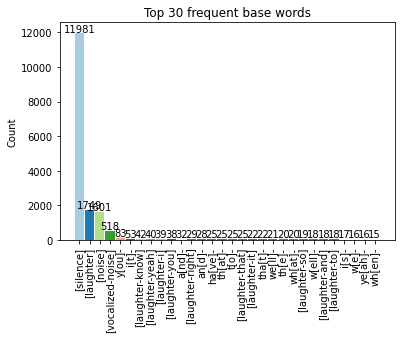

In [11]:
# data visualization of top 30 brace words
draw_distribution(dict(Counter(brace_words).most_common()[0:30]), 'Top 30 frequent base words')

## Fetching and Cleaning text

In [62]:
filepaths = []
topics = []
sentences = []

# Looping over conversations list to read the textual data from txt files
for i in range(len(conversations)):
    convo = fetch_clean_conversation(conversations[i][0])
    filepaths.append(conversations[i][0])
    topics.append(conversations[i][1])
    sentences.append(convo)

# Encoding the labels using fit transform of LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(topics)
label_dict = {str(i): list(label_encoder.classes_)[i] for i in range(len(list(label_encoder.classes_)))}
print(label_dict)

{'0': 'Bank', '1': 'Budget', '2': 'Credit', '3': 'Family', '4': 'Job', '5': 'Taxes'}


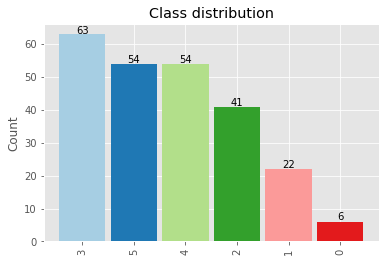

In [63]:
# Drawing class distribution
draw_distribution(dict(Counter(labels).most_common()), 'Class distribution')

Average length of conversations :  1322.2291666666667


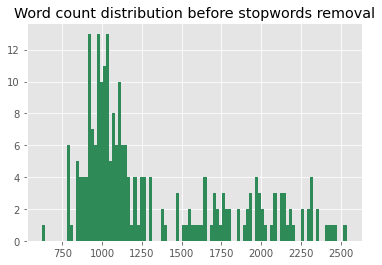

In [64]:
# Word length frequency distribution before stop words removal
print('Average length of conversations : ', statistics.mean([len(s.split()) for s in sentences]))
plt.hist([len(s.split()) for s in sentences], bins=100, color='seagreen')
plt.title('Word count distribution before stopwords removal')
plt.show()

Average length of conversations :  517.3625


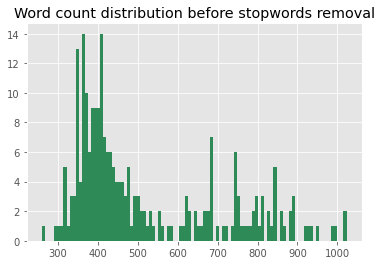

In [60]:
# Word length frequency distribution after stop words removal
stopwords = list(STOPWORDS)
stopwords.extend(['uh', 'um', 'huh', 'hum'])


sentences = [' '.join([word for word in sent.split() if word not in stopwords]) for sent in sentences]
print('Average length of conversations : ', statistics.mean([len(s.split()) for s in sentences]))
plt.hist([len(s.split()) for s in sentences], bins=100, color='seagreen')
plt.title('Word count distribution before stopwords removal')
plt.show()

In [18]:
# Training parameters
vocab_size = 5000
max_length = 500
embedding_dim = 128
oov_tok = '<OOV>'

## Tokenization

In [19]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

## Oversampling - SMOTE - Whole data

In [30]:
oversample = SMOTE(k_neighbors=5, random_state=1, sampling_strategy={0:40, 1:40})
undersample = RandomUnderSampler(random_state=1, sampling_strategy={3:54})

print('Class distribution before SMOTE : ', Counter(labels))
X, Y = oversample.fit_resample(padded, labels)
X, Y = undersample.fit_resample(X, Y)
print('Class distribution after SMOTE : ', Counter(Y))

Class distribution before SMOTE :  Counter({3: 63, 5: 54, 4: 54, 2: 41, 1: 22, 0: 6})
Class distribution after SMOTE :  Counter({3: 54, 4: 54, 5: 54, 2: 41, 0: 40, 1: 40})


## Random Sample train test split 

In [31]:
train_padded, test_padded, _train_labels, _test_labels = model_selection.train_test_split(X, Y, test_size=0.2, random_state=22)
print('Class distribution of train data : ', Counter(_train_labels))
print('Class distribution of test data : ', Counter(_test_labels))

cat_train_labels = np_utils.to_categorical(_train_labels)
cat_test_labels = np_utils.to_categorical(_test_labels)

Class distribution of train data :  Counter({3: 46, 5: 41, 4: 39, 2: 34, 1: 33, 0: 33})
Class distribution of test data :  Counter({4: 15, 5: 13, 3: 8, 1: 7, 0: 7, 2: 7})


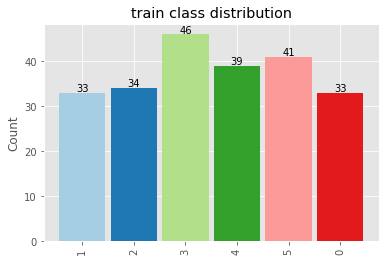

In [32]:
draw_distribution(dict(Counter(_train_labels)), 'train class distribution')

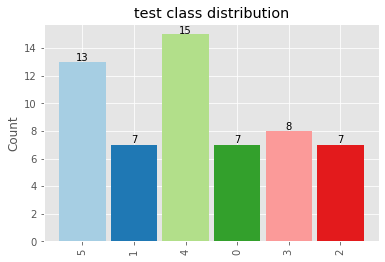

In [33]:
draw_distribution(dict(Counter(_test_labels)), 'test class distribution')

## Import pretrained embedding vectors

In [34]:
# Preparing embedding matric with the specified dimensions
embedding_matrix = create_embedding_matrix(embedding_vectors_path, tokenizer.word_index, embedding_dim)

## Embedding + Bidirectional LSTM

In [35]:
model = Sequential()

model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=False, weights=[embedding_matrix]))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(len(label_dict), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 739,590
Trainable params: 99,590
Non-trainable params: 640,000
_________________________________________________________________


In [37]:
history = model.fit(train_padded, cat_train_labels, epochs=50, validation_data=(test_padded, cat_test_labels))

Epoch 1/50
8/8 [==============================] - 6s 395ms/step - loss: 1.7666 - accuracy: 0.2330 - val_loss: 1.6787 - val_accuracy: 0.2982
Epoch 2/50
8/8 [==============================] - 2s 297ms/step - loss: 1.6280 - accuracy: 0.3982 - val_loss: 1.5877 - val_accuracy: 0.4561
Epoch 3/50
8/8 [==============================] - 2s 277ms/step - loss: 1.5150 - accuracy: 0.5058 - val_loss: 1.4574 - val_accuracy: 0.5614
Epoch 4/50
8/8 [==============================] - 2s 280ms/step - loss: 1.3054 - accuracy: 0.6749 - val_loss: 1.1657 - val_accuracy: 0.7018
Epoch 5/50
8/8 [==============================] - 2s 300ms/step - loss: 1.1355 - accuracy: 0.7133 - val_loss: 1.0082 - val_accuracy: 0.7895
Epoch 6/50
8/8 [==============================] - 2s 283ms/step - loss: 0.9935 - accuracy: 0.7425 - val_loss: 0.9520 - val_accuracy: 0.8070
Epoch 7/50
8/8 [==============================] - 3s 362ms/step - loss: 0.9451 - accuracy: 0.7422 - val_loss: 1.0621 - val_accuracy: 0.5263
Epoch 8/50
8/8 [====

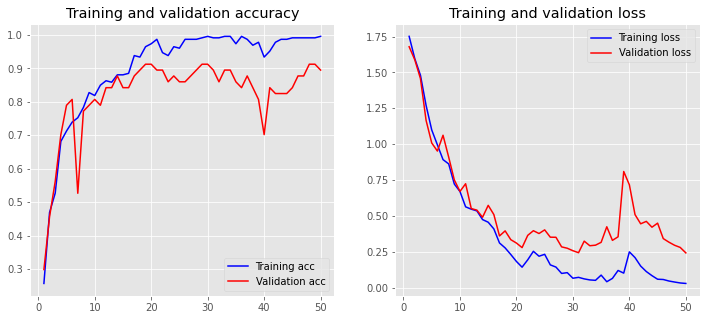

In [38]:
plot_history(history)

              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.67      0.57      0.62         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       0.94      1.00      0.97        15
           5       0.87      1.00      0.93        13

    accuracy                           0.89        57
   macro avg       0.88      0.86      0.86        57
weighted avg       0.89      0.89      0.89        57



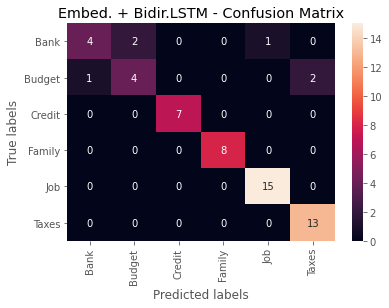

In [39]:
y_pred = model.predict(test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(cat_test_labels, axis=1)

# Printing confusion matric on test data
plot_results(y_test, y_pred, 'Embed. + Bidir.LSTM')

## Saving the tokenizer and model to models directory

In [54]:
# Saving tokenizer as a pickle file
with open(os.path.join(models_path, 'tokenizer.pickle'), 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Saving trained model file
model.save(os.path.join(models_path, 'classification'))

# Saving mapping_dict and max_len as a config file
with open(os.path.join(models_path, 'config.json'), 'w') as outfile:
    json.dump({'mapping': label_dict, 'maxlen': max_length}, outfile)

INFO:tensorflow:Assets written to: ./models/classification/assets


INFO:tensorflow:Assets written to: ./models/classification/assets
